# 초음파광물예측+추가callbacks+history

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# 실행할때마다 같은 결과를 출력하기 위한 seed값설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

### 데이터 탐색

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload() 
filename = list(uploaded.keys())[0]
filename #sonar.csv

Saving sonar.csv to sonar.csv


'sonar.csv'

In [ ]:
df = pd.read_csv(filename, header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R


In [ ]:
df[60].unique() 
#타겟은 2가지 array(['R', 'M'], dtype=object)

array(['R', 'M'], dtype=object)

In [ ]:
#원핫인코딩말고 레이블인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df[60].values)
y_encoded[95:100]
#array([1, 1, 0, 0, 0])

array([1, 1, 0, 0, 0])

In [ ]:
X = df.iloc[:, :-1].values
X.shape
#(208, 60)

(208, 60)

### 과적합을피하는방법1. Train/Test Dataset으로 나누기

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, random_state=seed
)

X_train.shape, X_test.shape
#((156, 60), (52, 60))

((156, 60), (52, 60))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(30, input_dim=60, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,151
Trainable params: 2,151
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델저장관련 환경설정
import os #디렉토리명령어
MODEL_DIR = './model/' #모델디렉토리
if not os.path.exists(MODEL_DIR):#없으면만들어라
    os.mkdir(MODEL_DIR)

In [ ]:
!ls -l

total 96
drwxr-xr-x 2 root root  4096 Feb 10 05:29 model
drwxr-xr-x 1 root root  4096 Feb  4 15:26 sample_data
-rw-r--r-- 1 root root 87776 Feb 10 05:26 sonar.csv


In [ ]:
# 모델 저장 조건 설정
modelpath = MODEL_DIR + "best{epoch:03d}-{val_loss:.4f}.hdf5"

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
#monitor='val_loss' 4가지중선택가능
#verbose=1 최소한보여줌/ 0안보여줌/ 2다보여줌
#save_best_only=True 물어보고이전보다좋으면저장, 아니면 모두다저장함;
# 자동 중단 설정

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=10, epochs=200, 
                    verbose=0, callbacks=[checkpointer, early_stopping]) 


Epoch 00001: val_loss improved from inf to 0.69731, saving model to ./model/best001-0.6973.hdf5

Epoch 00002: val_loss improved from 0.69731 to 0.68787, saving model to ./model/best002-0.6879.hdf5

Epoch 00003: val_loss did not improve from 0.68787

Epoch 00004: val_loss improved from 0.68787 to 0.68655, saving model to ./model/best004-0.6866.hdf5

Epoch 00005: val_loss improved from 0.68655 to 0.67902, saving model to ./model/best005-0.6790.hdf5

Epoch 00006: val_loss did not improve from 0.67902

Epoch 00007: val_loss improved from 0.67902 to 0.67329, saving model to ./model/best007-0.6733.hdf5

Epoch 00008: val_loss improved from 0.67329 to 0.66966, saving model to ./model/best008-0.6697.hdf5

Epoch 00009: val_loss improved from 0.66966 to 0.66496, saving model to ./model/best009-0.6650.hdf5

Epoch 00010: val_loss improved from 0.66496 to 0.66259, saving model to ./model/best010-0.6626.hdf5

Epoch 00011: val_loss improved from 0.66259 to 0.65587, saving model to ./model/best011-0.6

In [ ]:
#잘못된평가? 베스트모델로한것이아님
acc = model.evaluate(X_test, y_test)
print(f'Accuracy: {acc[1]:.4f}')
#Accuracy: 0.7885
#위에서 validation_split넣으니 0.8269로 올라감
#은닉층갯수,은닉층조절하니 0.8077 되려떨어짐 ㅠㅠ?

2/2 [==============================] - 0s 5ms/step - loss: 0.3968 - accuracy: 0.8077
Accuracy: 0.8077


In [ ]:
#베스트모델로평가해도 0.8269예전정확도복구된듯 
from tensorflow.keras.models import load_model

best_model = load_model('./model/best090-0.3723.hdf5') 
acc = best_model.evaluate(X_test, y_test) 
print(f'Accuracy: {acc[1]:.4f}')

2/2 [==============================] - 0s 3ms/step - loss: 0.3842 - accuracy: 0.8269
Accuracy: 0.8269


### 시각화

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
y_vloss=history.history['val_loss'] # y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_acc=history.history['accuracy'] # y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_vacc=history.history['val_accuracy']
y_loss=history.history['loss']

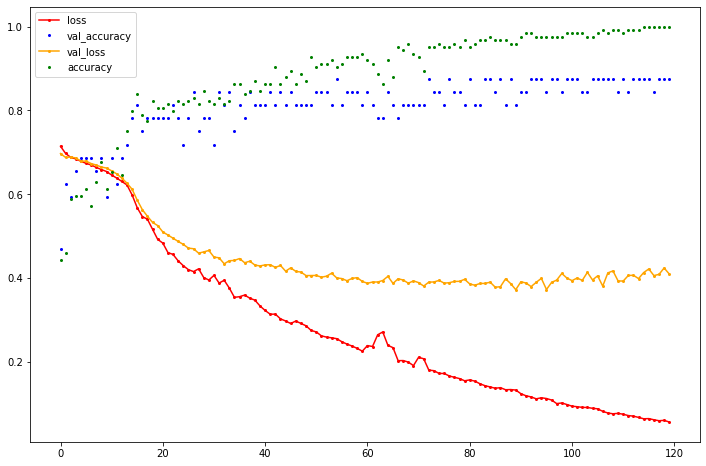

In [ ]:
x_len = np.arange(len(y_acc))
plt.figure(figsize=(12,8))
plt.plot(x_len, y_loss, "o-", c="red", markersize=2, label='loss')
plt.plot(x_len, y_vacc, "o", c="blue", markersize=2, label='val_accuracy')
plt.plot(x_len, y_vloss, "o-", c="orange", markersize=2, label='val_loss')
plt.plot(x_len, y_acc, "o", c="green", markersize=2, label='accuracy')
plt.legend()
plt.show()